In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

In [2]:
sys.path.append('../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

In [3]:
file_paths =      ["Pendulum_data/time/file2.dat", "Pendulum_data/time/file3.dat", 
                   "Pendulum_data/time/file4.dat", "Pendulum_data/time/file5.dat",
                   "Pendulum_data/time/file6.dat"]

data = []

for file_path in file_paths:
    temp = np.genfromtxt(file_path, delimiter='')  
    data.append(temp)

In [4]:
def linear(x, a, b):
    return a*x + b

def linear2(x, a):
    return a*x

def gauss_pdf(x, mu, sigma) :
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

def get_weighted_mean(x, x_err):
    mean_weighted = np.nansum(x/x_err**2) / np.nansum(1/x_err**2)
    err_weighted = np.sqrt(1/np.sum(1 / x_err**2)) 
    chi2 = np.nansum((x - mean_weighted)**2/x_err**2)
    print(stats.chi2.sf(chi2, len(x) - 1))
    return mean_weighted, err_weighted




def cleaning(x, show = True):
    items_removed = []
    index_removed = []
    sample_sigma = np.vectorize(lambda array: abs(array - mu) / sig)
    while True:
        mu  = np.mean(x)
        sig = np.std(x)
        #print(f'mu = {mu} and sigma = {sig}')
        
        z_values = sample_sigma(x)
        max_z = np.max(z_values)
        
        p  = stats.norm.sf(abs(max_z)) 
        if p < 1 / (len(x) * 2):
            index_z = np.where(z_values == max_z)[0][0]
            items_removed.append(x[index_z])
            index_removed.append(index_z)
            if show:
                print()
                print(f'datapoint: {x[index_z]}. p_value = {p:.4f} < Requirement = {1 / (len(x) * 2):.4f}')

            x = np.delete(x, index_z)
        else:
            print(f'Number of points removed: {len(items_removed)}')
            break
    return x, np.array(items_removed), np.array(index_removed)

# Uncertainties

In [5]:
data   = [array[:25] for array in data] # 25 measurements
swings = np.array(data[0]).T[0] # range from 1 to 25
periods = np.array(data).T[1].T
human_error = 0


combined_periods = np.mean(data, axis=0).T[1] # the combined average
combined_period_err = human_error + np.std(data, axis=0).T[1] / np.sqrt(5) # error on the each averaged datapoint

#print(combined_periods)
#print(combined_period_err)

In [6]:
# getting the times between measurements (periods)
periods_diff = [np.diff(np.insert(x, 0, 0)) for x in periods]

# error on the mean of the periods of different people
for i, period in enumerate (periods_diff):
    print(f' Person {i}: \u00B1 {np.std(period, axis = 0):.2f} s')

 Person 0: ± 0.03 s
 Person 1: ± 0.21 s
 Person 2: ± 0.05 s
 Person 3: ± 0.09 s
 Person 4: ± 0.30 s


## data-pruning

In [7]:
indices_removed = []
for i in range(len(periods_diff)):
    _, _, temp = cleaning(periods_diff[i], False)
    indices_removed.append(temp)

indices_removed = indices_removed[-1]
periods_corr = list(periods)

print(periods_corr[-1][indices_removed])
periods_corr[-1][indices_removed]  = np.nan

combined_periods_corr = np.nanmean(periods_corr, axis=0) # the combined average
lengths = np.count_nonzero(~np.isnan(periods_corr), axis=0)
combined_period_corr_err = human_error + np.nanstd(periods_corr, axis=0) / np.sqrt(lengths) # error on the each averaged datapoint

Number of points removed: 0
Number of points removed: 0
Number of points removed: 0
Number of points removed: 0
Number of points removed: 4
[  7.3306 118.4886 110.288  153.0579]


In [8]:
# after correction
periods_diff_corr = [np.diff(np.insert(x, 0, 0)) for x in periods]
for i, period in enumerate (periods_diff_corr):
    print(f' Person {i}: \u00B1 {np.nanstd(period, axis = 0):.2f} s')

 Person 0: ± 0.03 s
 Person 1: ± 0.21 s
 Person 2: ± 0.05 s
 Person 3: ± 0.09 s
 Person 4: ± 0.15 s


In [9]:
print(periods_diff_corr)

[array([8.617 , 8.5567, 8.5861, 8.5946, 8.5323, 8.6283, 8.5472, 8.5636,
       8.6415, 8.5642, 8.5735, 8.586 , 8.5646, 8.6086, 8.5543, 8.5975,
       8.5946, 8.6011, 8.578 , 8.5927, 8.603 , 8.5428, 8.6264, 8.568 ,
       8.6352]), array([8.9758, 8.2949, 8.7195, 8.5346, 8.4938, 8.7697, 8.6742, 8.3278,
       8.4716, 8.9094, 8.5415, 8.5388, 8.5637, 8.3799, 8.6868, 8.8504,
       8.737 , 8.3664, 8.4842, 8.5128, 8.9116, 8.5189, 8.2965, 8.8997,
       8.2932]), array([8.5199, 8.5083, 8.5543, 8.6465, 8.5644, 8.6362, 8.6059, 8.5525,
       8.5663, 8.5567, 8.6399, 8.4919, 8.6619, 8.5746, 8.6219, 8.5005,
       8.689 , 8.5105, 8.6315, 8.6333, 8.6243, 8.5783, 8.5628, 8.5649,
       8.6531]), array([8.6958, 8.4685, 8.6172, 8.6393, 8.4367, 8.5738, 8.7307, 8.489 ,
       8.667 , 8.6211, 8.7261, 8.4785, 8.5606, 8.6838, 8.4761, 8.7088,
       8.4034, 8.6909, 8.6537, 8.5316, 8.5763, 8.6771, 8.5867, 8.596 ,
       8.5451]), array([   nan,    nan, 8.4851, 8.5736, 8.5174, 8.4907, 8.7789, 8.4389,
       8

In [10]:
# Getting weighted mean on raw
w_p_r = get_weighted_mean(np.mean(periods_diff, axis=1), np.std(periods_diff, axis=1)/np.sqrt(5))

# Getting weighted mean on corrected
w_p_c = get_weighted_mean(np.nanmean(periods_diff_corr, axis=1), np.nanstd(periods_diff_corr, axis=1)/np.sqrt(np.count_nonzero(~np.isnan(periods_corr), axis=1)))

print(w_p_r, w_p_c)

0.9931468403950208
0.9359944734569635
(8.586367073891381, 0.010994356229200409) (8.586191705475022, 0.004880325495697679)


# Period finding

In [11]:
def get_period(x_data, y_data, y_errors, plot = True, label = 'fit'): 
    def chi2_linear(a, b):
        y_model = linear(x_data, a, b)
        chi2 = np.sum(((y_data - y_model) / y_errors) ** 2)
        return chi2

    chi2_linear_fit = Minuit(chi2_linear, a = 8.5,b = 0)
    chi2_linear_fit.errordef = 1.0
    chi2_linear_fit.migrad()
    fit_a =           chi2_linear_fit.values["a"]
    fit_b =           chi2_linear_fit.values["b"]
    fit_a_err =       chi2_linear_fit.errors["a"]
    fit_b_err =       chi2_linear_fit.errors["b"]

    print(f'a = {fit_a:.4f}  \u00B1 {fit_a_err:.4f} , b = {fit_b:.2f} \u00B1 {fit_b_err:.2f}')
    print(f'p_chi2 = {stats.chi2.sf(chi2_linear_fit.fval, len(x_data) - 2):.3}')
    print(chi2_linear_fit.fval, len(x_data) - 2)
    
    if plot:
        plt.scatter(x_data, y_data, label = label + ' data', color = 'black')
        plt.plot(x_data, linear(x_data, fit_a, fit_b), label = 'Fit', color = 'red')
        #plt.errorbar(x_data, y_data, yerr = y_errors , label = 'errorbars')
        plt.legend()

def get_period2(x_data, y_data, y_errors, plot = True, label = 'fit'): 
    def chi2_linear(a):
        y_model = linear2(x_data, a)
        chi2 = np.sum(((y_data - y_model) / y_errors) ** 2)
        return chi2

    chi2_linear_fit = Minuit(chi2_linear, a = 8.5)
    chi2_linear_fit.errordef = 1.0
    chi2_linear_fit.migrad()
    fit_a =           chi2_linear_fit.values["a"]
    fit_a_err =       chi2_linear_fit.errors["a"]

    print(f'a = {fit_a:.4f}  \u00B1 {fit_a_err:.4f}')
    print(f'p_chi2 = {stats.chi2.sf(chi2_linear_fit.fval, len(x_data) - 2):.3}')
    print(chi2_linear_fit.fval, len(x_data) - 2)
    
    if plot:
        plt.scatter(x_data, y_data, label = label + ' data', color = 'black')
        plt.plot(x_data, linear2(x_data, fit_a), label = 'Fit', color = 'red')
        #plt.errorbar(x_data, y_data, yerr = y_errors , label = 'errorbars')
        plt.legend()


In [12]:
print(combined_period_err)

[0.25457847 0.20523378 0.23357859 0.23564429 0.23213733 0.26524664
 0.24335525 0.2435772  0.24311098 0.25174359 0.25654767 0.25313354
 0.24765298 0.31064895 0.23318882 0.26606351 0.28722216 0.28423409
 0.26484188 0.21621785 0.29673532 0.33214036 0.28194875 0.26828043
 0.29209941]


## Uncorrected

a = 8.5718  ± 0.0036
p_chi2 = 1.0
6.596932665588481 23


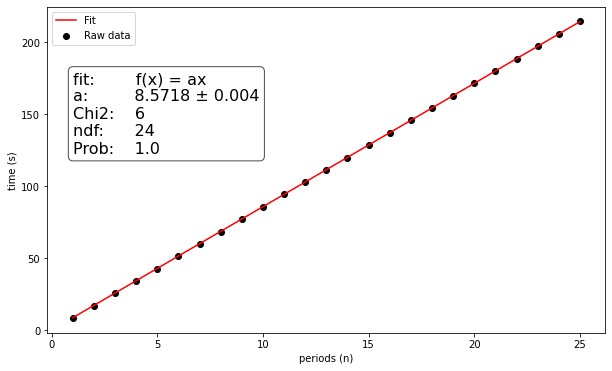

In [13]:
plt.figure(figsize = (10,6))
get_period2(swings, combined_periods, combined_period_err, plot = True, label = 'Raw')
plt.xlabel('periods (n)')
plt.ylabel('time (s)')

d = ['fit:        f(x) = ax',
     f'a:         {8.5718} \u00B1 {0.004}',
     f'Chi2:    {6}',
     f'ndf:      {24}',
     f'Prob:    {1.0}']
text_box = '\n'.join(d)  # Join the lines with newline characters


plt.text(1.02, 120.9, text_box, fontsize=16, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.show()

In [14]:
stats.chi2.sf(0.6, 3)

0.8964323733419115

## Corrected

a = 8.5831  ± 0.0021
p_chi2 = 0.697
19.07664038602527 23


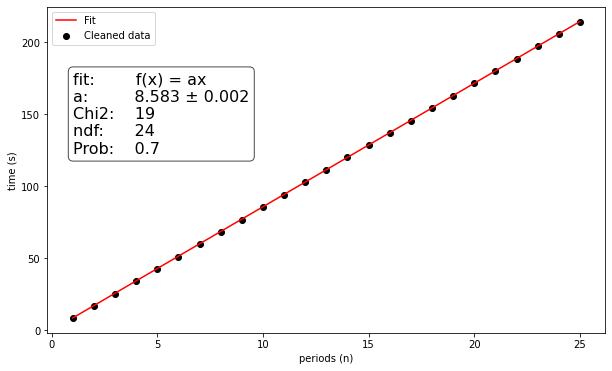

In [15]:
plt.figure(figsize = (10,6))
get_period2(swings, combined_periods_corr, combined_period_corr_err, plot = True,  label = 'Cleaned')
plt.xlabel('periods (n)')
plt.ylabel('time (s)')

d = ['fit:        f(x) = ax',
     f'a:         {8.583} \u00B1 {0.002}',
     f'Chi2:    {19}',
     f'ndf:      {24}',
     f'Prob:    {0.70}']
text_box = '\n'.join(d)  # Join the lines with newline characters


plt.text(1.02, 120.9, text_box, fontsize=16, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.show()

In [16]:
merged_array = np.concatenate(periods_diff)
print(merged_array)

[8.617  8.5567 8.5861 8.5946 8.5323 8.6283 8.5472 8.5636 8.6415 8.5642
 8.5735 8.586  8.5646 8.6086 8.5543 8.5975 8.5946 8.6011 8.578  8.5927
 8.603  8.5428 8.6264 8.568  8.6352 8.9758 8.2949 8.7195 8.5346 8.4938
 8.7697 8.6742 8.3278 8.4716 8.9094 8.5415 8.5388 8.5637 8.3799 8.6868
 8.8504 8.737  8.3664 8.4842 8.5128 8.9116 8.5189 8.2965 8.8997 8.2932
 8.5199 8.5083 8.5543 8.6465 8.5644 8.6362 8.6059 8.5525 8.5663 8.5567
 8.6399 8.4919 8.6619 8.5746 8.6219 8.5005 8.689  8.5105 8.6315 8.6333
 8.6243 8.5783 8.5628 8.5649 8.6531 8.6958 8.4685 8.6172 8.6393 8.4367
 8.5738 8.7307 8.489  8.667  8.6211 8.7261 8.4785 8.5606 8.6838 8.4761
 8.7088 8.4034 8.6909 8.6537 8.5316 8.5763 8.6771 8.5867 8.596  8.5451
 7.3306 8.6977 8.4851 8.5736 8.5174 8.4907 8.7789 8.4389 8.585  8.66
 8.5854 8.5418 8.6029 8.2006 9.0123 8.5427 8.5029 8.5114 8.6818 8.825
 8.267  8.3711 8.7727 8.7795 8.3443]


In [17]:
cleaned_array, _, _ = cleaning(merged_array, show = False);
print(len(cleaned_array))

Number of points removed: 15
110


# Chi2 fit binned fit

50
8
3.4025067347640294


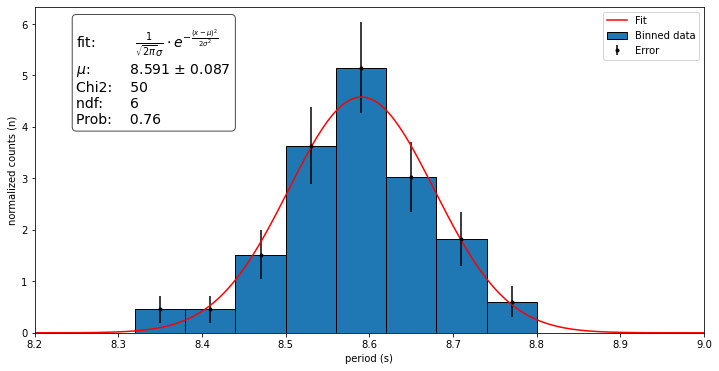

a = 8.5905  ± 0.0871 , b = 0.0086 ± 0.0080
p_chi2 = 0.7568923096364395


In [18]:
Nbins = 50
xmin, xmax = 7, 10
arr = cleaned_array

counts, bin_edges = np.histogram(arr, bins=Nbins, range=(xmin, xmax))
print(len(counts))

mask = counts > 0
bin_widths = np.diff(bin_edges)[mask]
x = ((bin_edges[1:] + bin_edges[:-1])/2)[mask]
y = counts[mask]
sy = np.sqrt(counts)[mask]
print(len(x))


total_area = np.sum(y * bin_widths)
y_norm = y / total_area
sy_norm = sy / total_area

def chi2_gauss(mu, sigma):
    y_model =  gauss_pdf(x, mu, sigma)
    chi2 = np.sum(((y_norm - y_model) / sy_norm) ** 2)
    return chi2

gauss_fit = Minuit(chi2_gauss, 8.5, 1) #   
gauss_fit.errordef = 1
gauss_fit.migrad()          # Perform the actual fit

# extract fit values
mu, sigma = gauss_fit.values[:]
mu_err, sigma_err = gauss_fit.errors[:]
Chi2_bin = gauss_fit.fval
print(Chi2_bin)
#Ndof_bin =  gauss_fit.nfit - gauss_fit.npar       # this is weird

# plot results
plt.figure(figsize = (12,6))
X = np.linspace(7, 10, 1000)
plt.bar(x, y_norm, width=bin_widths, align='center', edgecolor='black', label = 'Binned data')
plt.plot(X, gauss_pdf(X, mu, sigma), label='Fit', color = 'red')
plt.errorbar(x, y_norm, yerr=sy_norm, fmt='.', color='black', label='Error')
plt.xlabel('period (s)')
plt.ylabel('normalized counts (n)')
plt.xlim(8.2,9)

formatted_string = rf'fit: $\qquad$  $\frac{{1}}{{\sqrt{{2\pi}}\sigma}} \cdot e^{{-\frac{{(x-\mu)^2}}{{2\sigma^2}}}}$'

d = [ formatted_string,
     fr'$\mu$:         {8.591} $\pm$ {0.087}',
     f'Chi2:    {50}',
     f'ndf:      {6}',
     f'Prob:    {stats.chi2.sf(Chi2_bin, len(x) - 2):.2f}']
text_box = '\n'.join(d)  # Join the lines with newline characters


plt.text(8.25, 4, text_box, fontsize=14, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


plt.legend()
plt.show()

# print results

print(f'a = {mu:.4f}  \u00B1 {sigma:.4f} , b = {mu_err:.4f} \u00B1 {sigma_err:.4f}')
print(f'p_chi2 = {stats.chi2.sf(Chi2_bin, len(x) - 2)}')

# find length of pendulum (L)

In [19]:
# skip last person
ruler_length, lazer_length, height_from_floor, block_height = np.genfromtxt('Pendulum_data/metadata.csv', delimiter=',', skip_header = 1)[0:5].T
obs_err = 0.0005

ruler_length          = ruler_length[0:4]
avg_ruler_length      = np.mean(ruler_length)
ruler_err             = np.sqrt((np.std(ruler_length) / np.sqrt(len(ruler_length)))**2 + obs_err**2)

avg_lazer_length      = np.mean(lazer_length)
lazer_err             = np.std(lazer_length) / np.sqrt(len(lazer_length))

avg_height_from_floor = np.mean(height_from_floor)
height_from_floor_err = np.sqrt((np.std(height_from_floor) / np.sqrt(len(height_from_floor)))**2 + obs_err**2)

block_height          = block_height / 200
avg_block_height      = np.mean(block_height) 
block_height_err      = np.sqrt((np.std(block_height) / np.sqrt(len(block_height)))**2 + obs_err**2)

lazer_L               = avg_lazer_length - avg_height_from_floor + avg_block_height
lazer_prop_err        = np.sqrt(lazer_err**2 + height_from_floor_err**2 + block_height_err**2)

weighted_L, weighted_L_err  = get_weighted_mean(np.array([lazer_L, avg_ruler_length]), np.array([lazer_prop_err, ruler_err]))

print(f'ruler length: {avg_ruler_length:.4f} \u00B1 {ruler_err:.4f}')
print(f'lazer length: {lazer_L:.4f} \u00B1 {lazer_prop_err:.4f}')
print(f'weighted length:{weighted_L:.4f} \u00B1 {weighted_L_err:.4f}')

1.135682775187251e-77
ruler length: 18.3525 ± 0.0012
lazer length: 18.3882 ± 0.0015
weighted length:18.3665 ± 0.0009


In [20]:
print(avg_ruler_length, avg_lazer_length, avg_height_from_floor, avg_block_height*2)

18.3525 18.729400000000002 0.356 0.02968


In [21]:
print(len(block_height))

5


In [24]:
def get_g(L, T):
    return np.round(L * (2 * np.pi / T)**2, 5)

g_lazer = get_g(lazer_L, 8.5831)
g_ruler = get_g(avg_ruler_length, 8.5831)
g_weight = get_g(weighted_L, 8.5867)


print(g_lazer, g_ruler)

9.85398 9.83482
